In [1]:
import pandas as pd 
import os
os.chdir('/home/spankaew/Git/astrologics')
import astrologics as le
import seaborn as sns
import matplotlib.pyplot as plt

/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


# Load model path into logic_ensemble object

In [2]:
model_path = '/home/spankaew/Git/astrologics/models/Invasion/'
model = le.LogicEnsemble(model_path, project_name = 'Invasion')
model.create_simulation()

Simulation object created


# Create simulation trajectory from the simulation
When we perform the simulation, the result of the timestep node activity can be visualized using dimension reduction method such as `pca`.

In [3]:
model.simulation.simulation_df = pd.read_csv('/home/spankaew/Git/astrologics/tmp/Invasion_simulation_new_v2.csv')

In [4]:
model.create_trajectory()
model.trajectory.pca_trajectory()

Trajectory object created


From the visualization, we can then try to group together models with simular simulation activity via clustering. 

In `logic_ensemble`, we utilize the package called `tslearn` - a toolkit to perform analysis on time series data. 

The timeseries clustering method included in this toolkit includes : 

- euclidean

- dynamic time warping (dtw) 

- softdtw.

The calculated clustering will be embeded into the trajectory matrix

In [5]:
import numpy as np
# Setup the 
pca_df = model.trajectory.pca_df
pca_df.model_id = pca_df.model_id.astype('category')
model_name = pca_df.model_id.cat.categories

simulation_df = model.simulation.simulation_df
simulation_df.model_id = simulation_df.model_id.astype('category')
node_list = simulation_df.columns.drop(['timepoint','model_id'])

model_original_all = {}
for i in model_name:
    model_original = simulation_df.loc[simulation_df.model_id == i,node_list].values
    model_original_all[i] = np.array(model_original)
pca_all_trajectory = np.array(list(model_original_all.values()))

100%|██████████| 1025/1025 [01:01<00:00, 16.54it/s]
/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hi

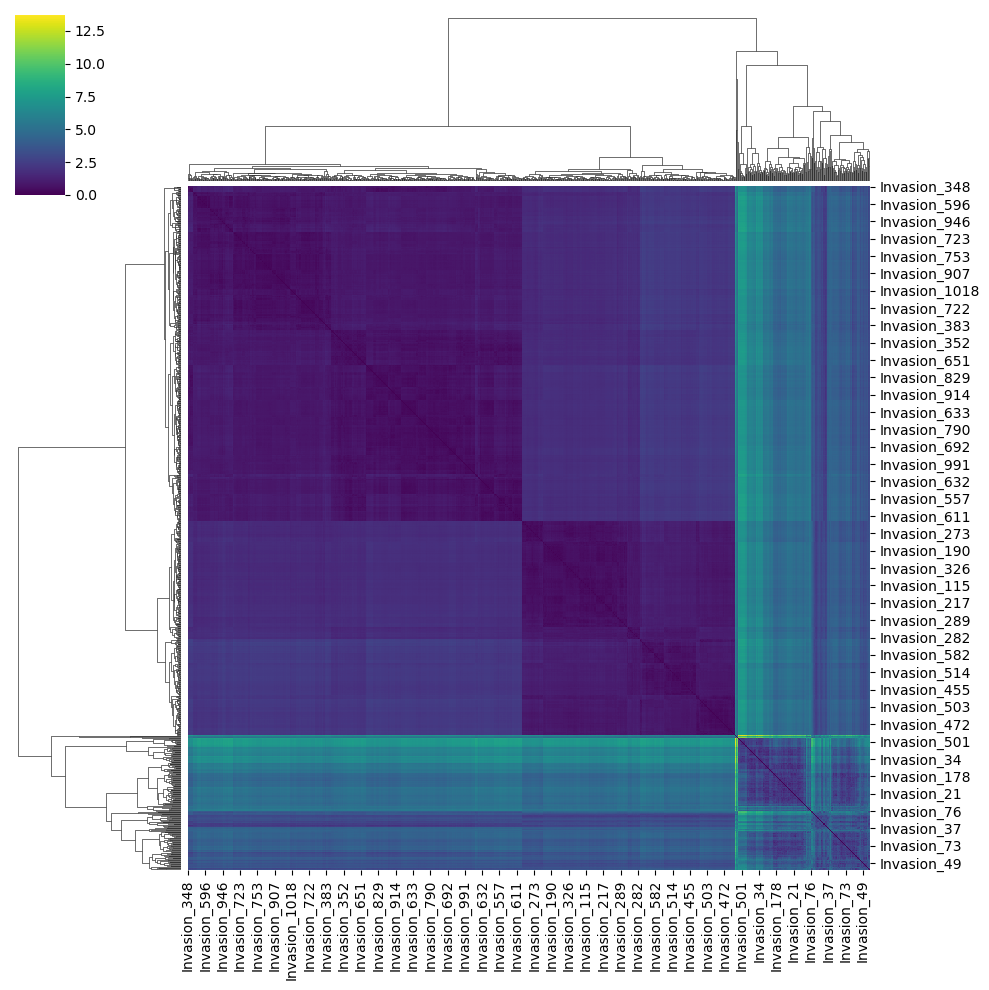

In [6]:
from tslearn.metrics import dtw
from tqdm import tqdm

# Initialize an empty distance matrix
num_trajectories = len(pca_all_trajectory)
distance_matrix = np.zeros((num_trajectories, num_trajectories))

# Calculate DTW distance for each pair of trajectories
for i in tqdm(range(num_trajectories)):
    for j in range(num_trajectories):
        distance_matrix[i, j] = dtw(pca_all_trajectory[i], pca_all_trajectory[j])

# Display the distance matrix
distance_matrix = pd.DataFrame(distance_matrix, index=model_name, columns=model_name)
sns.clustermap(distance_matrix, cmap='viridis', figsize=(10,10))

/tmp/ipykernel_331217/3281558711.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


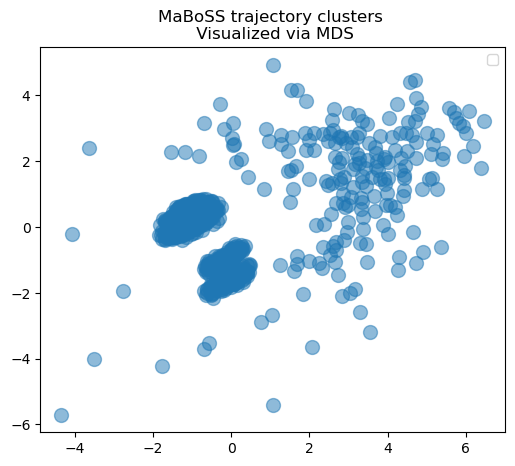

In [7]:
# Visualize clusters with MDS
from sklearn.manifold import MDS

# Visualize clusters with MDS
#distance_matrix = model.succession_diagram.distance_matrix
mds = MDS(random_state=12345, dissimilarity="precomputed")
coords = mds.fit_transform(distance_matrix)

plt.figure(figsize=(6, 5))
plt.scatter(coords[:, 0], coords[:, 1], alpha=0.5, s = 100)
plt.legend()
plt.title('MaBoSS trajectory clusters \n Visualized via MDS')
#plt.savefig('/home/spankaew/Git/astrologics/figures/model_clusters/BonesisTutorial_trajMDS_v2.pdf')

plt.show()

plt.close()

In [8]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=8, random_state=12345)
kmeans.fit(distance_matrix)
clusters = kmeans.labels_
cluster_dict = dict(zip(list(model_name),list(clusters)))

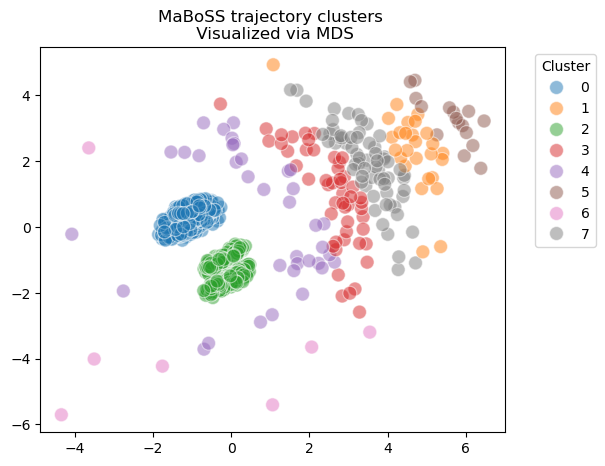

INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


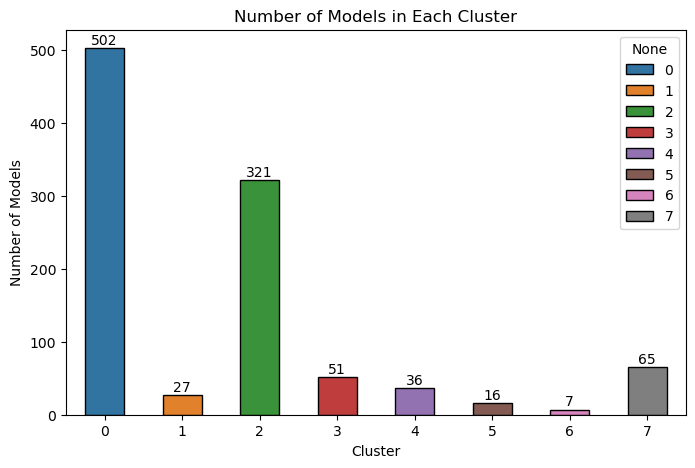

In [9]:
# Map the group colors based on the cluster dictionary
group_colors = distance_matrix.index.map(cluster_dict)
group_colors = group_colors.astype('category')  # Convert to numeric codes for coloring

# Add colors to the scatter plot using seaborn
plt.figure(figsize=(6, 5))
sns.scatterplot(x=coords[:, 0], y=coords[:, 1], hue=group_colors, palette='tab10', s=100, alpha=0.5)

# Customize the plot
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('MaBoSS trajectory clusters \n Visualized via MDS')
plt.savefig('/home/spankaew/Git/astrologics/figures/model_clusters/InvasionTutorial_trajMDS_trajcluster_colored_seaborn.pdf', bbox_inches='tight')

plt.show()
plt.close()

# Count the number of models in each cluster
cluster_counts = pd.Series(cluster_dict).value_counts()
cluster_counts = cluster_counts.sort_index()

# Create a bar chart
plt.figure(figsize=(8, 5))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, hue=cluster_counts.index, palette='tab10', width=0.5, edgecolor = 'black')

# Add the number of models on top of each bar
for index, value in enumerate(cluster_counts):
    plt.text(index, value + 1, str(value), ha='center', va='bottom', fontsize=10)

# Customize the plot
plt.xlabel('Cluster')
plt.ylabel('Number of Models')
plt.title('Number of Models in Each Cluster')
plt.xticks(rotation=0)
plt.show()

In [10]:
# Convert the cluster dictionary to a DataFrame
cluster_df = pd.DataFrame(list(cluster_dict.items()), columns=['Model_ID', 'Cluster'])
selected_model = cluster_df['Model_ID'][cluster_df['Cluster'].isin([0,2])]
selected_model

4       Invasion_1000
5       Invasion_1001
6       Invasion_1002
7       Invasion_1003
8       Invasion_1004
            ...      
1019     Invasion_995
1020     Invasion_996
1021     Invasion_997
1022     Invasion_998
1023     Invasion_999
Name: Model_ID, Length: 823, dtype: object

In [60]:
import numpy as np

simulation_df_sub = simulation_df[simulation_df.model_id.isin(selected_model)]
simulation_df_sub.model_id = simulation_df_sub.model_id.astype('str')
node_list = simulation_df_sub.columns.drop(['timepoint','model_id'])

model_name = simulation_df_sub.model_id.unique()

model_original_all = {}
for i in model_name:
    model_original = simulation_df_sub.loc[simulation_df_sub.model_id == i,node_list].values
    model_original_all[i] = np.array(model_original)
pca_all_trajectory = np.array(list(model_original_all.values()))

/tmp/ipykernel_315897/1180893950.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  simulation_df_sub.model_id = simulation_df_sub.model_id.astype('str')


100%|██████████| 823/823 [00:39<00:00, 20.89it/s]
/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hier

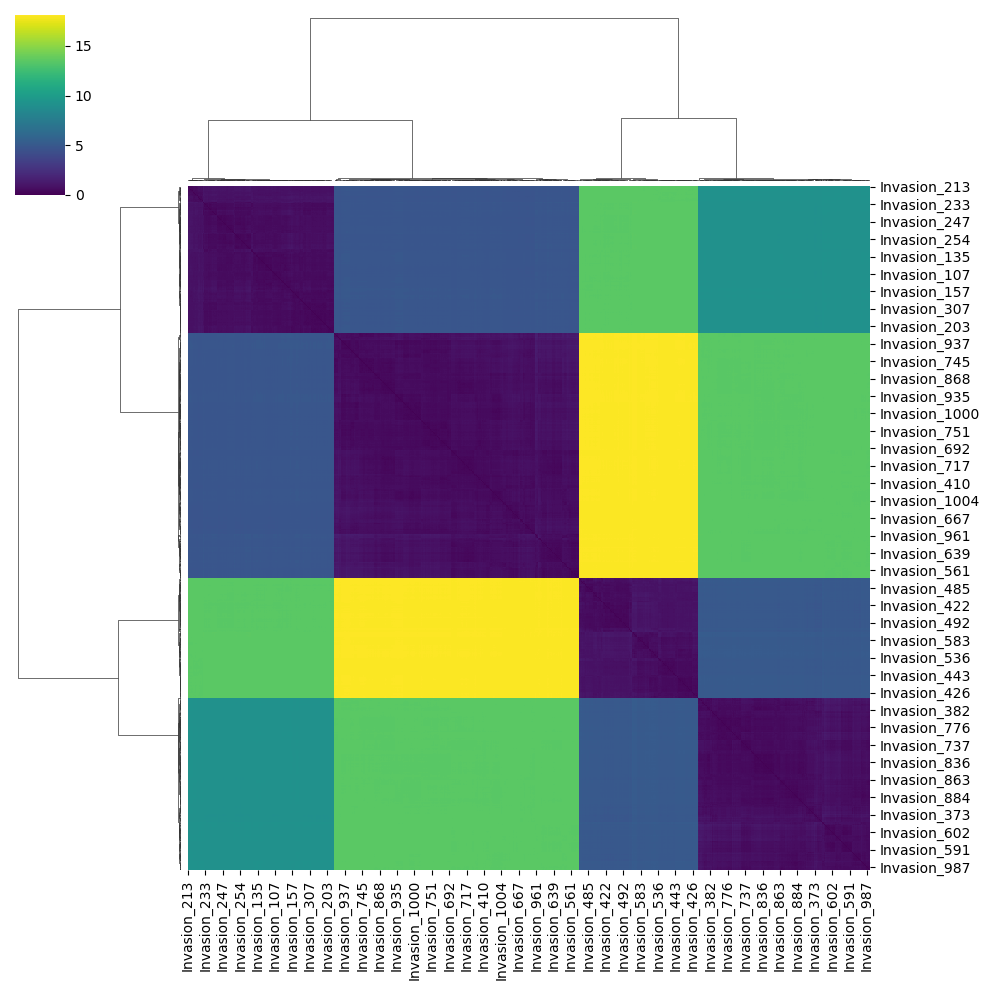

In [58]:
from tslearn.metrics import dtw
from tqdm import tqdm

# Initialize an empty distance matrix
num_trajectories = len(pca_all_trajectory)
distance_matrix = np.zeros((num_trajectories, num_trajectories))

# Calculate DTW distance for each pair of trajectories
for i in tqdm(range(num_trajectories)):
    for j in range(num_trajectories):
        distance_matrix[i, j] = dtw(pca_all_trajectory[i], pca_all_trajectory[j])

# Display the distance matrix
distance_matrix = pd.DataFrame(distance_matrix, index=model_name, columns=model_name)
sns.clustermap(distance_matrix, cmap='viridis', figsize=(10,10))

/tmp/ipykernel_315897/3815233600.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


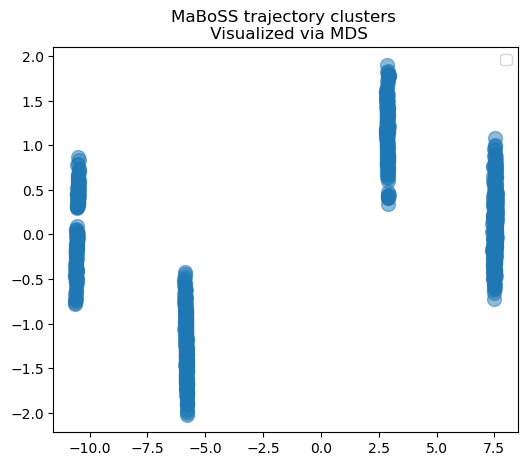

In [59]:
# Visualize clusters with MDS
from sklearn.manifold import MDS

# Visualize clusters with MDS
#distance_matrix = model.succession_diagram.distance_matrix
mds = MDS(dissimilarity='precomputed', random_state=12345)
coords = mds.fit_transform(distance_matrix)

plt.figure(figsize=(6, 5))
plt.scatter(coords[:, 0], coords[:, 1], alpha=0.5, s = 100)
plt.legend()
plt.title('MaBoSS trajectory clusters \n Visualized via MDS')
#plt.savefig('/home/spankaew/Git/astrologics/figures/model_clusters/BonesisTutorial_trajMDS_v2.pdf')

plt.show()

plt.close()

In [30]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=12345, n_init=100)
kmeans.fit(coords)
clusters = kmeans.labels_
cluster_dict = dict(zip(list(model_name),list(clusters)))

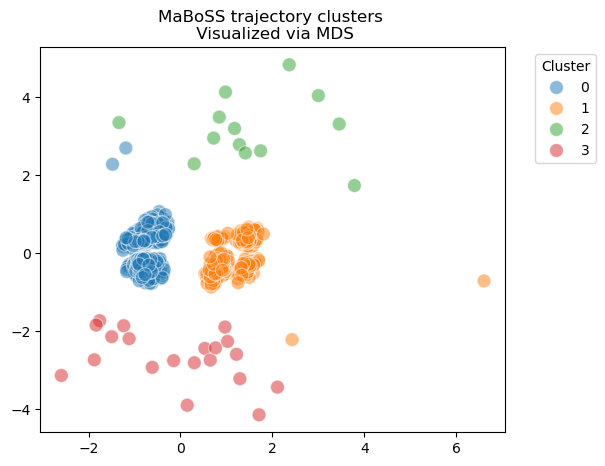

INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


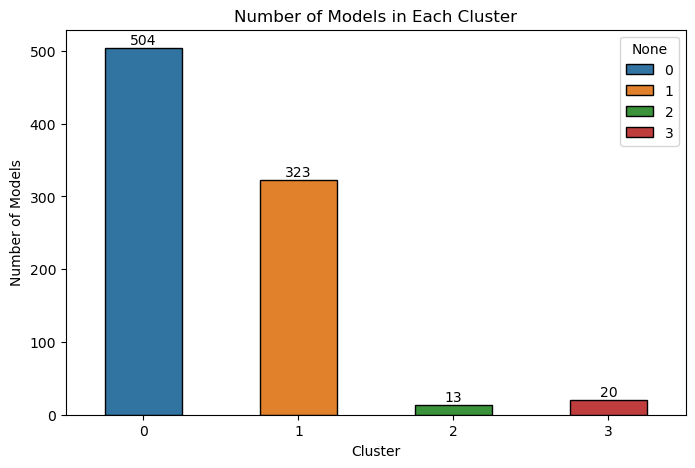

In [31]:
# Map the group colors based on the cluster dictionary
group_colors = distance_matrix.index.map(cluster_dict)
group_colors = group_colors.astype('category')  # Convert to numeric codes for coloring

# Add colors to the scatter plot using seaborn
plt.figure(figsize=(6, 5))
sns.scatterplot(x=coords[:, 0], y=coords[:, 1], hue=group_colors, palette='tab10', s=100, alpha=0.5)

# Customize the plot
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('MaBoSS trajectory clusters \n Visualized via MDS')
#plt.savefig('/home/spankaew/Git/astrologics/figures/model_clusters/InvasionTutorial_trajMDS_trajcluster_colored_seaborn.pdf', bbox_inches='tight')

plt.show()
plt.close()

# Count the number of models in each cluster
cluster_counts = pd.Series(cluster_dict).value_counts()
cluster_counts = cluster_counts.sort_index()

# Create a bar chart
plt.figure(figsize=(8, 5))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, hue=cluster_counts.index, palette='tab10', width=0.5, edgecolor = 'black')

# Add the number of models on top of each bar
for index, value in enumerate(cluster_counts):
    plt.text(index, value + 1, str(value), ha='center', va='bottom', fontsize=10)
cluster_dict
# Customize the plot
plt.xlabel('Cluster')
plt.ylabel('Number of Models')
plt.title('Number of Models in Each Cluster')
plt.xticks(rotation=0)
plt.show()

In [39]:
import pandas as pd

# Group by 'timepoint' and calculate variance for each gene
variance_results = simulation_df_sub.groupby('timepoint')[simulation_df_sub.columns[:-2]].var()
variance_results['avg'] = variance_results.mean(axis = 1)
sns.clustermap(variance_results.drop(columns = ['avg']), row_cluster=False, cmap = 'viridis', figsize = (15,7))

TypeError: agg function failed [how->var,dtype->object]

/tmp/ipykernel_287834/40250956.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  simulation_df_sub['type'] = simulation_df_sub['model_id'].map(cluster_dict)


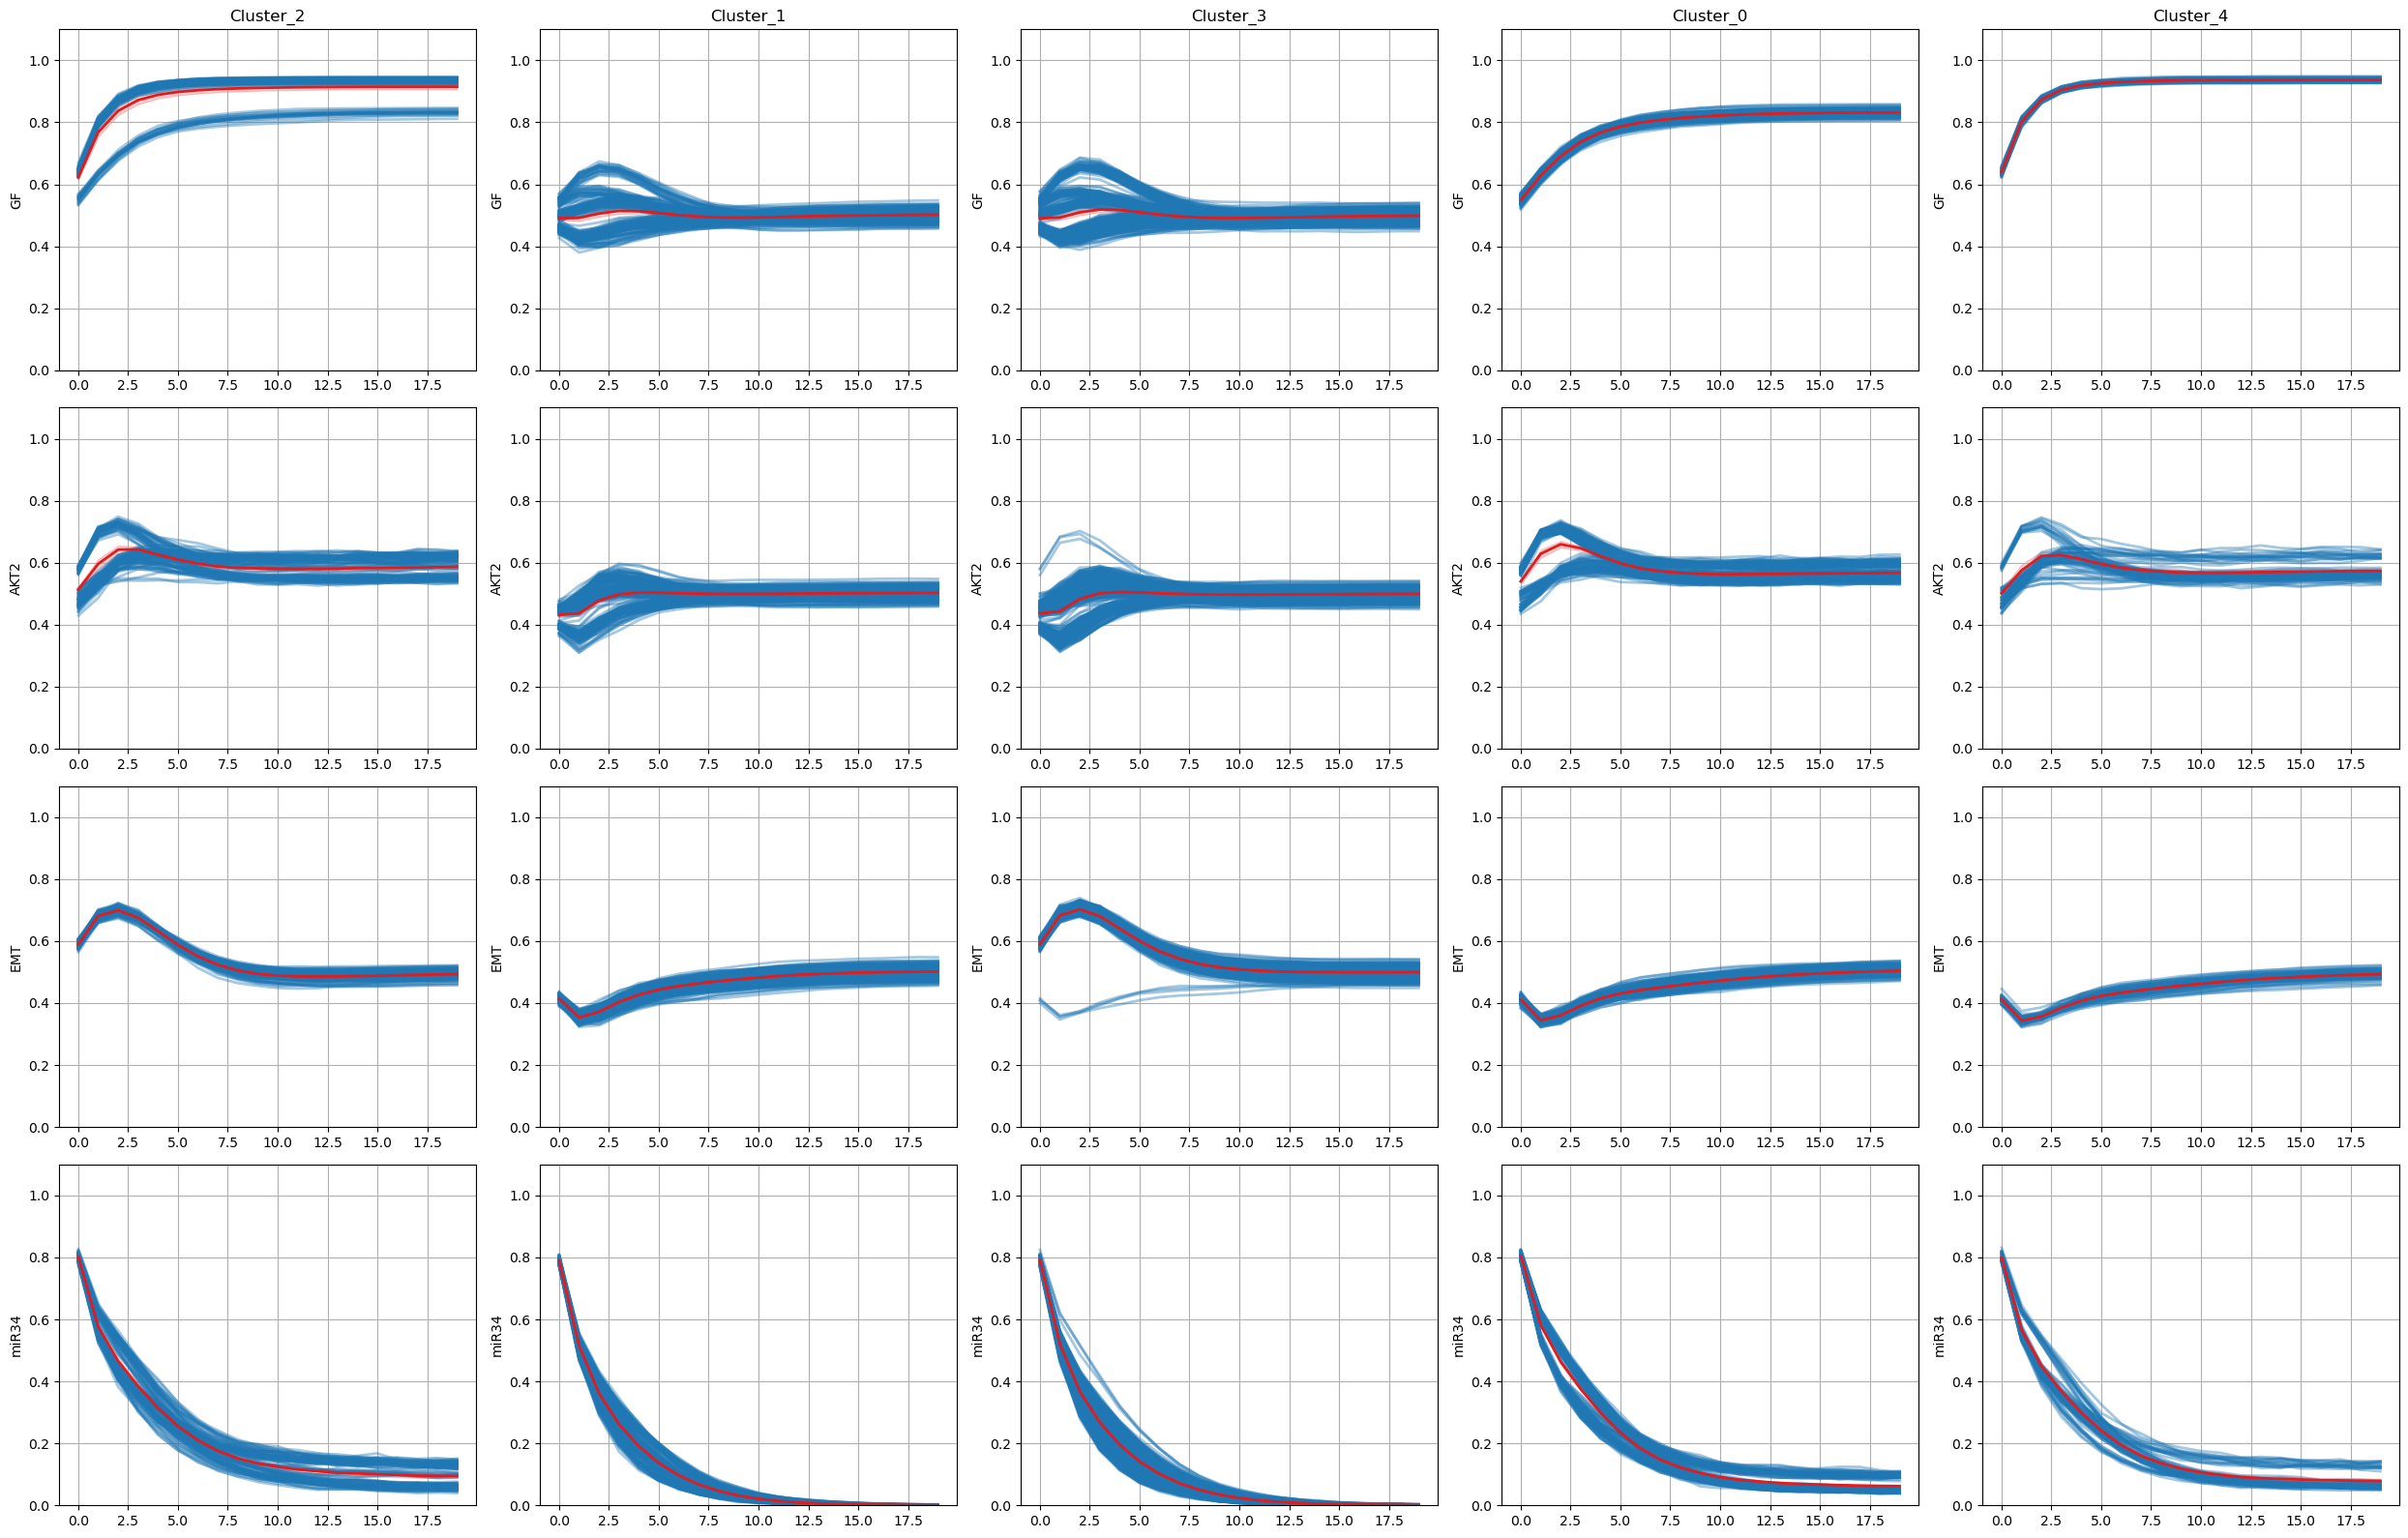

In [60]:
# Setup the gene list
selected_genes = ['GF', 'AKT2','EMT','miR34']
num_timesteps = 20
simulation_df_sub['type'] = simulation_df_sub['model_id'].map(cluster_dict)
cluster_type = list(simulation_df_sub.type.unique())

# Function to create matrix for each condition
def create_vis_matrix(cluster_type):
    vis = simulation_df_sub.loc[simulation_df_sub['type'] == cluster_type]
    vis = vis[selected_genes + ['timepoint', 'model_id']]
    vis = vis[vis.timepoint.isin(range(0, num_timesteps))]
    vis['model_id'] = vis['model_id'].astype('str')
    vis['type'] = cluster_type
    return vis

# Create matrices for each condition
vis_matrices = [create_vis_matrix(i) for i in cluster_type]

# Plot with Seaborn
plt.figure(figsize=(len(cluster_type) * 5, len(selected_genes) * 4))
n_genes = len(selected_genes)

for i, gene in enumerate(selected_genes):
    for j, vis in enumerate(vis_matrices):
        plt.subplot(n_genes, len(cluster_type), len(cluster_type) * i + j + 1)
        plot = sns.lineplot(data=vis, x='timepoint', y=gene, lw=2, 
                            units = 'model_id', estimator = None, alpha = 0.4)
        plot.set_ylim(0, 1.1)
        plot.set_ylabel(gene)
        plot.set_xlabel(None)
        plot.grid(True)
        if i == 0:
            plot.set_title(f'Cluster_{cluster_type[j]}')
            
for i, gene in enumerate(selected_genes):
    for j, vis in enumerate(vis_matrices):
        plt.subplot(n_genes, len(cluster_type), len(cluster_type) * i + j + 1)
        plot = sns.lineplot(data=vis, x='timepoint', y=gene, lw=2, hue = 'type',palette='Set1')
        plot.set_ylim(0, 1.1)
        plot.set_ylabel(gene)
        plot.grid(True)
        plot.set_xlabel(None)
        plot.legend().remove()

plt.tight_layout()
plt.show()
plt.close()

/tmp/ipykernel_135651/3026716732.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


Text(0.5, 1.0, 'MaBoSS trajectory clusters \n Visualized via MDS')

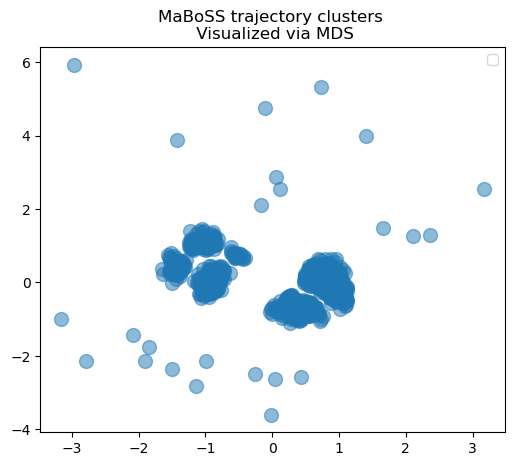

In [82]:
distance_matrix_sub = distance_matrix.loc[selected_model, selected_model]
# Visualize clusters with MDS
#distance_matrix = model.succession_diagram.distance_matrix
mds = MDS(dissimilarity='precomputed', random_state=12345)
coords = mds.fit_transform(distance_matrix_sub)

plt.figure(figsize=(6, 5))
plt.scatter(coords[:, 0], coords[:, 1], alpha=0.5, s = 100)
plt.legend()
plt.title('MaBoSS trajectory clusters \n Visualized via MDS')

# Create logic function matrix
In this part of the script, we load models' logic function into a matrix. This matrix can then be transformed into a Disjunctive Normal Form (DNF) which allow us to identify clause of components that can activate each node. 

In [ ]:
model.create_logic()


Loading models logics


100%|██████████| 1025/1025 [00:18<00:00, 54.36it/s]


Concatenate results into matrix


100%|██████████| 1025/1025 [00:01<00:00, 606.72it/s]


Logic object created


TypeError: 'logic' object is not subscriptable

In [66]:
model.logic.model_logic = model.logic.model_logic[selected_model]
model.logic.create_flattend_logic_clause()

Flatten models logic clauses


100%|██████████| 823/823 [00:00<00:00, 3115444.22it/s]


Concatenate results into matrix


100%|██████████| 823/823 [00:00<00:00, 995.60it/s] 

Flattend logic clause created


Invasion_0               4
Invasion_1               3
Invasion_10              4
Invasion_100             3
Invasion_1000            0
                        ..
Invasion_996             0
Invasion_997             0
Invasion_998             0
Invasion_999             0
Invasion_Master_Model    4
Length: 1025, dtype: int32

In [70]:
from sklearn.preprocessing import OrdinalEncoder
model_cluster = pd.Series(cluster_dict)
model_logic = model.logic.model_logic

var_logic_clust = pd.DataFrame()
for i in list([0,2]):
    model_logic_sub = model_logic.transpose().loc[list(model_cluster.index[model_cluster == i])]
    #model_logic_sub = model_logic_sub.drop(['logic_cluster'], axis = 1)
    var_logic_length = []
    for j in model_logic_sub.columns:
        num_logic = model_logic_sub[j].value_counts().size
        var_logic_length.append(num_logic)
    var_logic_length = pd.DataFrame(var_logic_length, columns = ['logic_length'], index = model_logic_sub.columns)
    var_logic_clust = pd.concat([var_logic_clust, var_logic_length], axis = 1, ignore_index = False)
var_logic_clust.columns = list([0,2])

model_logic_t= model_logic.transpose()

# Ordinal encoding
encoder = OrdinalEncoder()
encoded_data = encoder.fit_transform(model_logic_t)
encoded_df = pd.DataFrame(encoded_data, columns=model_logic_t.columns)

sort_index = encoded_df.max().sort_values().index

var_logic_clust= var_logic_clust.loc[sort_index] 

In [72]:
from scipy.stats import chi2_contingency

test = model.logic.logic_clause_flattend
test = test.transpose()
test['group'] = test.index.map(cluster_dict)
# Assuming 'df' is a DataFrame with samples as rows and features as columns,
# and 'group' is a column indicating group membership.

# Step 1: Identify constant features.
constant_features = [col for col in test.columns if col != 'group' and test[col].nunique() == 1]

# Step 2 & 3: For non-constant features, perform chi-square test.
marker_features = []
varied_features = []

for col in test.columns:
    if col == 'group' or col in constant_features:
        continue
    contingency_table = pd.crosstab(test[col], test['group'])
    chi2, p, _, _ = chi2_contingency(contingency_table)
    if p < 0.0001:  # Adjust threshold as needed after multiple testing correction.
        marker_features.append(col)
    else:
        varied_features.append(col)

# Create a color palette for the groups
unique_groups = test['group'].unique()
palette = sns.color_palette("tab10", len(unique_groups))
group_colors = test['group'].map(dict(zip(unique_groups, palette)))

# Create a dictionary to store features and their groups
feature_groups = {
    'Feature': constant_features + varied_features + marker_features,
    'Group': (['Constant'] * len(constant_features)) +
             (['Varied'] * len(varied_features)) +
             (['Marker'] * len(marker_features))
}

# Convert the dictionary to a DataFrame
features_df = pd.DataFrame(feature_groups)

# Add the node features into the DataFrame
features_df['Node'] = features_df['Feature'].str.split('_', n=1, expand=True)[0]

/tmp/ipykernel_315897/3517451482.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_var_logic_length.index,
/tmp/ipykernel_315897/3517451482.py:6: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(x=sorted_var_logic_length.index,


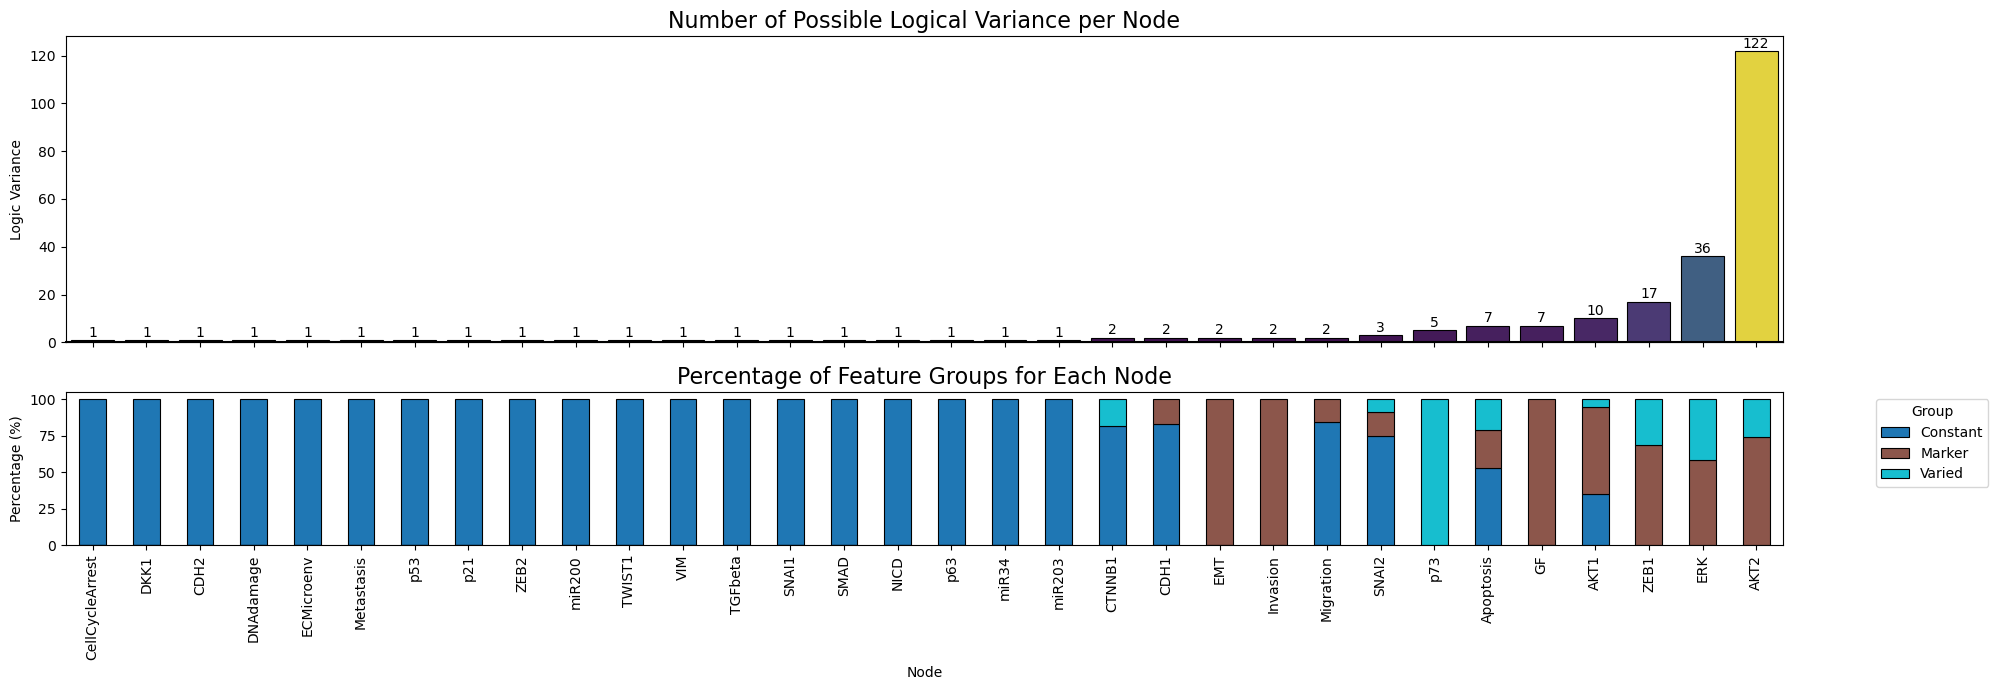

In [73]:
# Create a figure with two subplots sharing the x-axis
fig, axes = plt.subplots(2, 1, figsize=(20, 7), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

# Plot the first barplot
sorted_var_logic_length = encoded_df.max().sort_values() + 1
sns.barplot(x=sorted_var_logic_length.index, 
            y=sorted_var_logic_length.values, 
            palette=sns.color_palette("viridis", as_cmap=True)(sorted_var_logic_length.values / sorted_var_logic_length.max()), 
            edgecolor='black', linewidth=0.8, ax=axes[0])

# Customize the first plot
axes[0].axhline(0, color="k", clip_on=False)
axes[0].set_ylabel('Logic Variance')
axes[0].set_title('Number of Possible Logical Variance per Node', fontsize=16)
axes[0].tick_params(axis='x', rotation=90)
for index, value in enumerate(sorted_var_logic_length.astype('int')):
    axes[0].text(index, value + 0.1, str(value), ha='center', va='bottom', fontsize=10)

# Plot the second stacked barplot
features_df_grouped = features_df.groupby(['Node', 'Group']).size().unstack(fill_value=0)
features_df_grouped = features_df_grouped.loc[sorted_var_logic_length.index]
features_df_percentage = features_df_grouped.div(features_df_grouped.sum(axis=1), axis=0) * 100
features_df_percentage.plot(kind='bar', stacked=True, colormap='tab10', ax=axes[1], edgecolor='black', linewidth=0.8)

# Customize the second plot
axes[1].set_ylabel('Percentage (%)')
axes[1].set_xlabel('Node')
axes[1].set_title('Percentage of Feature Groups for Each Node', fontsize=16)
axes[1].legend(title='Group', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].tick_params(axis='x', rotation=90)

# Adjust layout
plt.tight_layout()
plt.show()

In [77]:
from sklearn.preprocessing import OrdinalEncoder
model_cluster = cluster_df.loc[cluster_df['Cluster'].isin([0,2])].set_index('Model_ID')
model_cluster = model_cluster.squeeze()
model_logic = model.logic.model_logic
model_logic = model_logic[selected_model]

var_logic_clust = pd.DataFrame()
for i in list(model_cluster.unique()):
    model_logic_sub = model_logic.transpose().loc[list(model_cluster.index[model_cluster == i])]
    #model_logic_sub = model_logic_sub.drop(['logic_cluster'], axis = 1)
    var_logic_length = []
    for j in model_logic_sub.columns:
        num_logic = model_logic_sub[j].value_counts().size
        var_logic_length.append(num_logic)
    var_logic_length = pd.DataFrame(var_logic_length, columns = ['logic_length'], index = model_logic_sub.columns)
    var_logic_clust = pd.concat([var_logic_clust, var_logic_length], axis = 1, ignore_index = False)
var_logic_clust.columns = list(model_cluster.unique())

model_logic_t= model_logic.transpose()

# Ordinal encoding
encoder = OrdinalEncoder()
encoded_data = encoder.fit_transform(model_logic_t)
encoded_df = pd.DataFrame(encoded_data, columns=model_logic_t.columns)

sort_index = encoded_df.max().sort_values().index

var_logic_clust= var_logic_clust.loc[sort_index] 

In [ ]:
from scipy.stats import chi2_contingency

test = model.logic.logic_clause_flattend
test = test.transpose()
test = test.loc[selected_model]
test['group'] = test.index.map(model.trajectory.cluster_dict)
# Assuming 'df' is a DataFrame with samples as rows and features as columns,
# and 'group' is a column indicating group membership.

# Step 1: Identify constant features.
constant_features = [col for col in test.columns if col != 'group' and test[col].nunique() == 1]

# Step 2 & 3: For non-constant features, perform chi-square test.
marker_features = []
varied_features = []

for col in test.columns:
    if col == 'group' or col in constant_features:
        continue
    contingency_table = pd.crosstab(test[col], test['group'])
    chi2, p, _, _ = chi2_contingency(contingency_table)
    if p < 0.0001:  # Adjust threshold as needed after multiple testing correction.
        marker_features.append(col)
    else:
        varied_features.append(col)

# Create a color palette for the groups
unique_groups = test['group'].unique()
palette = sns.color_palette("tab10", len(unique_groups))
group_colors = test['group'].map(dict(zip(unique_groups, palette)))

# Create a dictionary to store features and their groups
feature_groups = {
    'Feature': constant_features + varied_features + marker_features,
    'Group': (['Constant'] * len(constant_features)) +
             (['Varied'] * len(varied_features)) +
             (['Marker'] * len(marker_features))
}

# Convert the dictionary to a DataFrame
features_df = pd.DataFrame(feature_groups)

# Add the node features into the DataFrame
features_df['Node'] = features_df['Feature'].str.split('_', n=1, expand=True)[0]

/tmp/ipykernel_135651/3517451482.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_var_logic_length.index,
/tmp/ipykernel_135651/3517451482.py:6: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(x=sorted_var_logic_length.index,


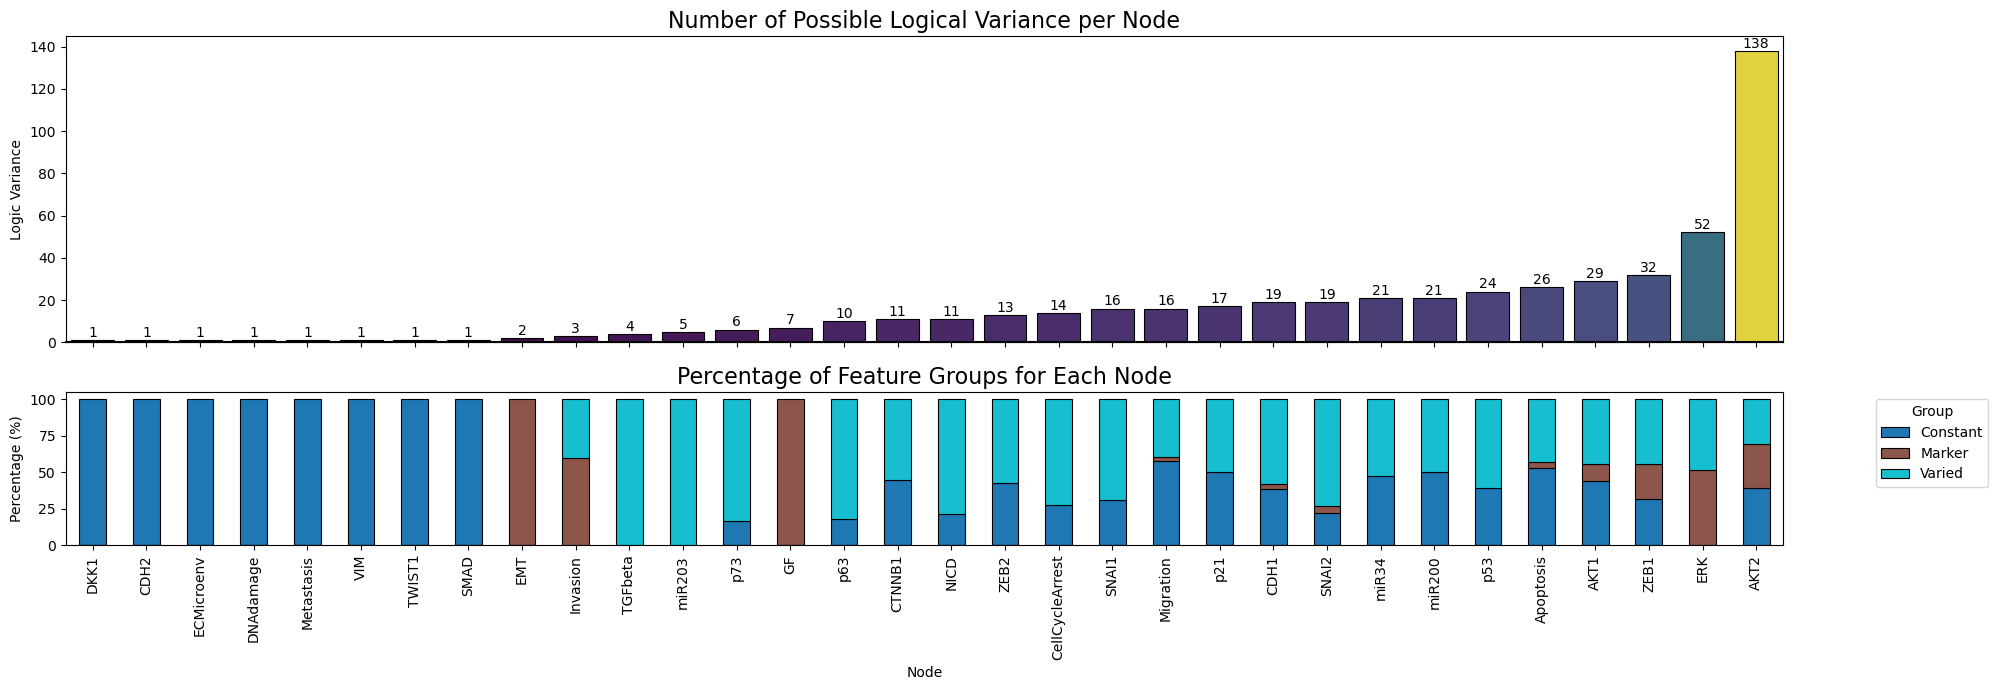

In [81]:
# Create a figure with two subplots sharing the x-axis
fig, axes = plt.subplots(2, 1, figsize=(20, 7), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

# Plot the first barplot
sorted_var_logic_length = encoded_df.max().sort_values() + 1
sns.barplot(x=sorted_var_logic_length.index, 
            y=sorted_var_logic_length.values, 
            palette=sns.color_palette("viridis", as_cmap=True)(sorted_var_logic_length.values / sorted_var_logic_length.max()), 
            edgecolor='black', linewidth=0.8, ax=axes[0])

# Customize the first plot
axes[0].axhline(0, color="k", clip_on=False)
axes[0].set_ylabel('Logic Variance')
axes[0].set_title('Number of Possible Logical Variance per Node', fontsize=16)
axes[0].tick_params(axis='x', rotation=90)
for index, value in enumerate(sorted_var_logic_length.astype('int')):
    axes[0].text(index, value + 0.1, str(value), ha='center', va='bottom', fontsize=10)

# Plot the second stacked barplot
features_df_grouped = features_df.groupby(['Node', 'Group']).size().unstack(fill_value=0)
features_df_grouped = features_df_grouped.loc[sorted_var_logic_length.index]
features_df_percentage = features_df_grouped.div(features_df_grouped.sum(axis=1), axis=0) * 100
features_df_percentage.plot(kind='bar', stacked=True, colormap='tab10', ax=axes[1], edgecolor='black', linewidth=0.8)

# Customize the second plot
axes[1].set_ylabel('Percentage (%)')
axes[1].set_xlabel('Node')
axes[1].set_title('Percentage of Feature Groups for Each Node', fontsize=16)
axes[1].legend(title='Group', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].tick_params(axis='x', rotation=90)

# Adjust layout
plt.tight_layout()
plt.show()

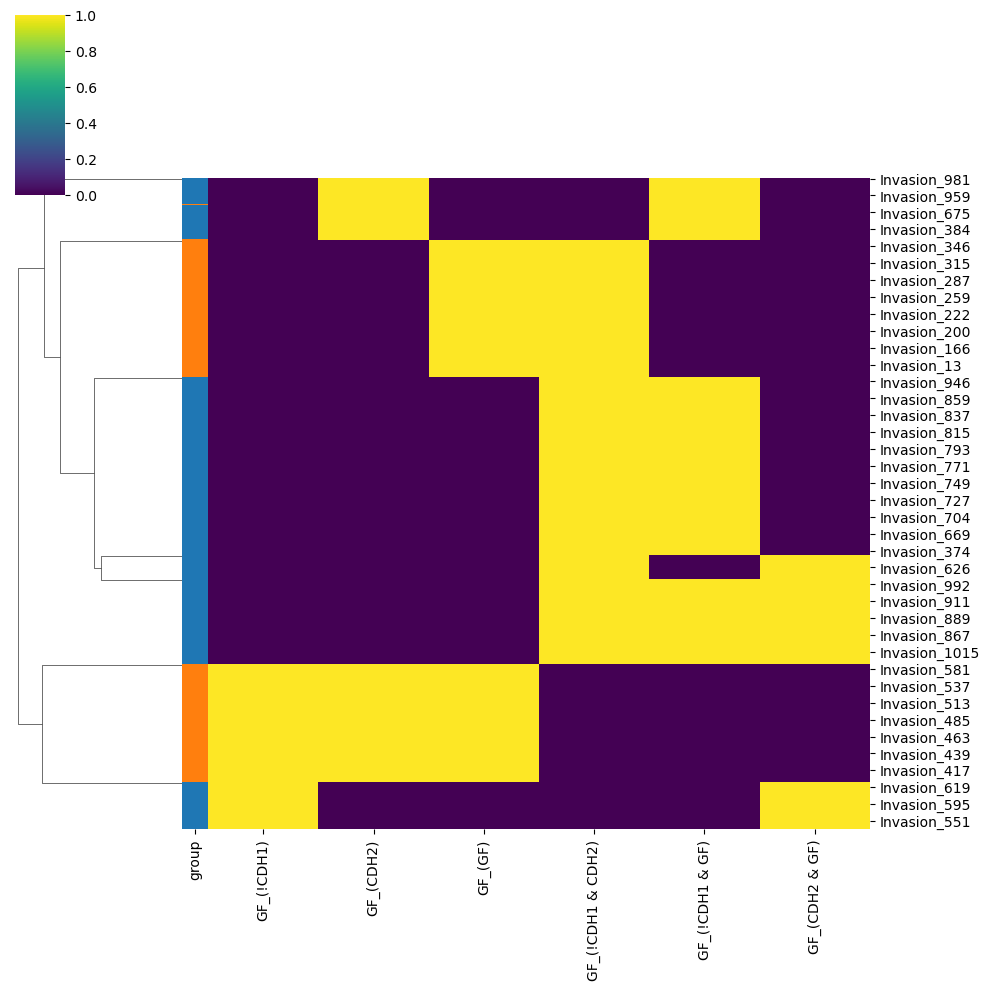

In [92]:
selected_features = features_df.loc[(features_df['Node'] == 'GF') & (features_df['Group'] == 'Marker')].Feature

# Create a color palette for the groups
unique_groups = test['group'].unique()
palette = sns.color_palette("tab10", len(unique_groups))
group_colors = test['group'].map(dict(zip(unique_groups, palette)))

# Create the clustermap with row colors
sns.clustermap(test[selected_features], col_cluster = False, row_cluster = True,
               cmap='viridis', figsize=(10, 10), row_colors=group_colors)

Model_ID
Invasion_0               2
Invasion_1000            2
Invasion_1001            2
Invasion_1002            2
Invasion_1003            2
                        ..
Invasion_996             2
Invasion_997             2
Invasion_998             2
Invasion_999             2
Invasion_Master_Model    2
Name: Cluster, Length: 512, dtype: int64

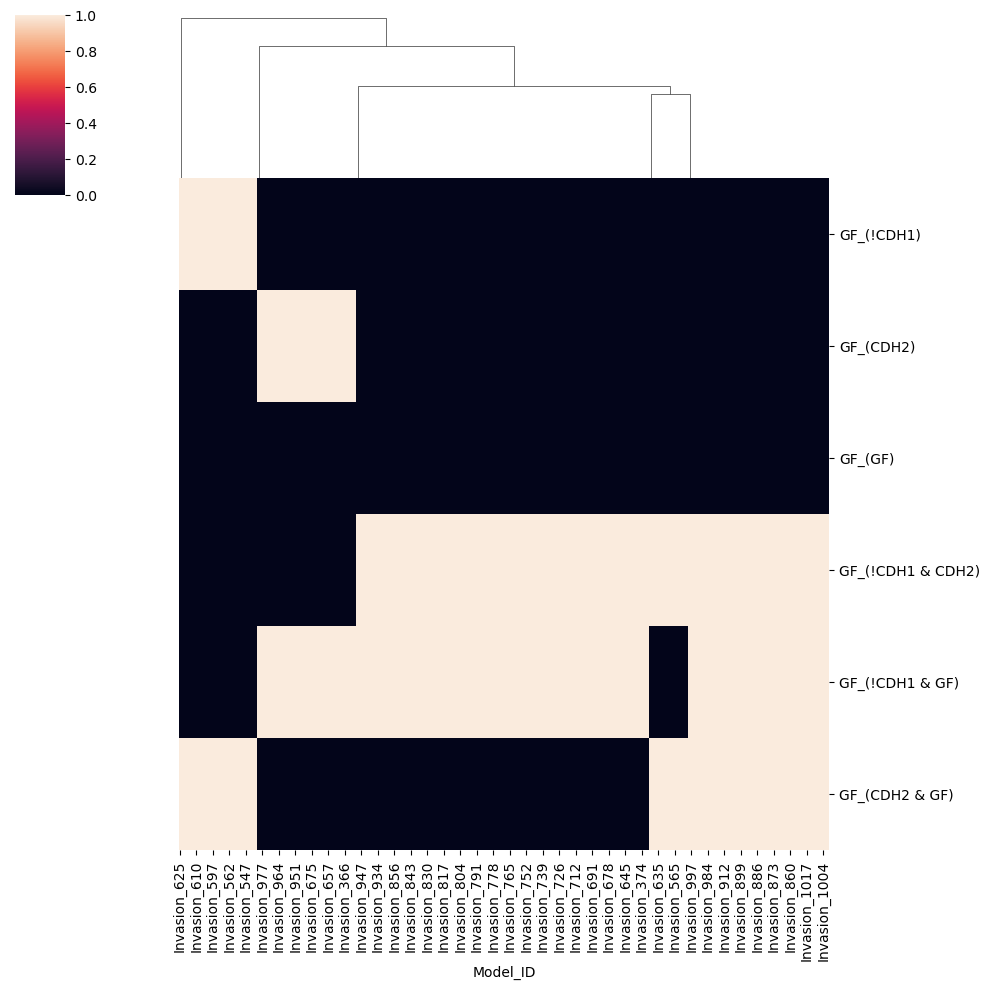

In [112]:
model_vis_cluster1 = test.loc[model_cluster[model_cluster==2].index, selected_features]
sns.clustermap(model_vis_cluster1.transpose(), row_cluster = False)

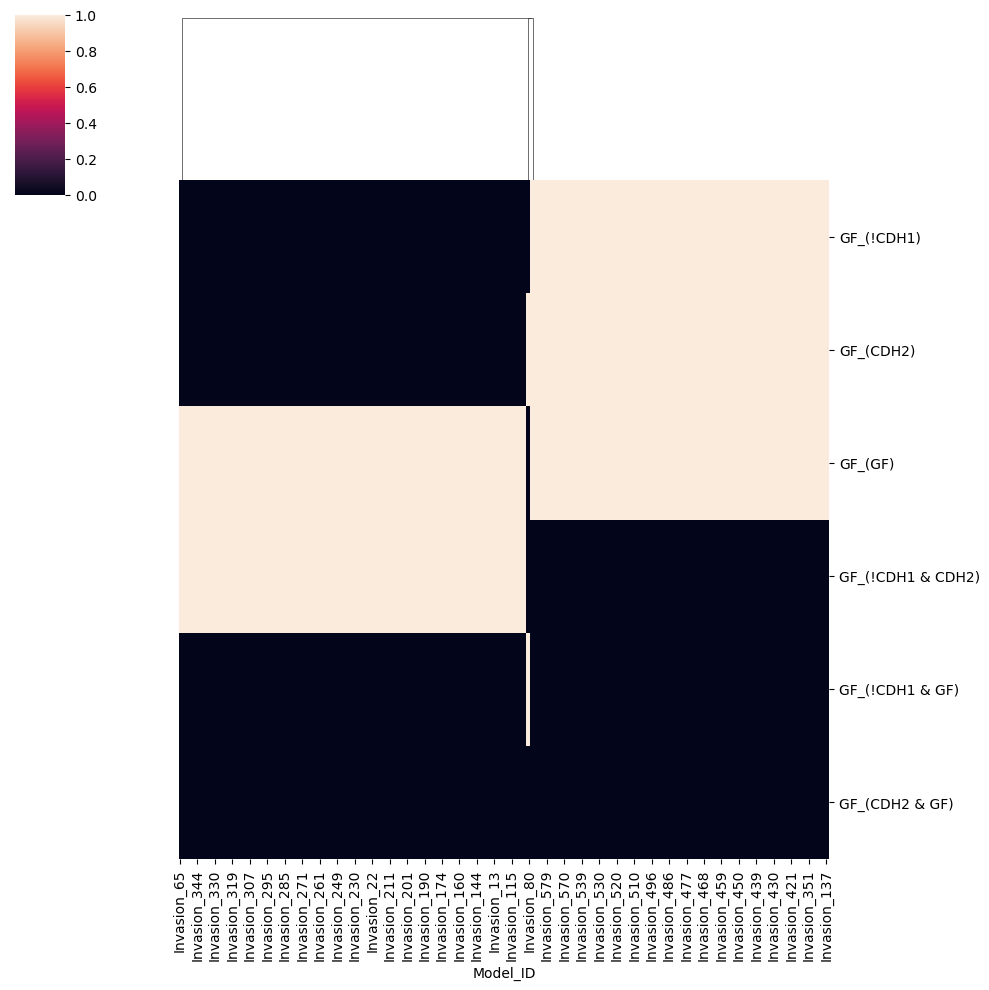

In [110]:
model_vis_cluster2 = test.loc[model_cluster[model_cluster==0].index, selected_features]
sns.clustermap(model_vis_cluster2.transpose(), row_cluster = False)